# Introduction to Data Science - Final Work
The goal of this notebook is to make a machine learning solution using the knowledge acquired in Introduction to Data Science discipline

# Imports

In [153]:
import kagglehub
import pandas as pd
import os
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
from nltk.tokenize import TweetTokenizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn import metrics
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 1- Business Understanding 
Dataset Overview
This dataset is designed for predicting user depression based on Reddit post content. It encompasses data from six specific subreddits:

* Teenagers
* Depression
* SuicideWatch
* DeepThoughts
* Happy

Posts from the Depression and SuicideWatch subreddits are labeled as 1 to indicate depression. Posts from the other subreddits are labeled as 0, representing non-depressed or normal content.

- Subreddit: The subreddit where the post was shared
- Title: The title provided by the user for the post
- Body: The content of the post written by the user
- Upvotes: The number of upvotes the post received
- Created UTC: The time the post was created, given in UTC epoch time
- Number of Comments: The total count of comments on the post
- Label: The category assigned to the post, where 0 indicates normal and 1 indicates depressed

# 2 - Data Understending

In [187]:
path = kagglehub.dataset_download("rishabhkausish/reddit-depression-dataset")
csv_file = os.path.join(path, "reddit_depression_dataset.csv") 
df = pd.read_csv(csv_file)


/var/folders/bf/j88nff6527n1q_zj02k2gf8r0000gn/T/ipykernel_78556/939651867.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


In [265]:
print(df.shape)

(19325, 6)


In [266]:
df.head()

,title,body,upvotes,created_utc,num_comments,label
1990777,I feel like I am smart enough that I should be...,I dont mean to say I am _extremely_ smart and ...,11.0,2009-06-19 03:01:24,11.0,1.0
1990779,My story...,Hi everyone Ive been using reddit for a long t...,21.0,2009-06-19 23:09:04,10.0,1.0
1990784,This is very difficult for me. The one person ...,This is an alt account She reads reddit as do ...,17.0,2009-06-22 03:45:11,15.0,1.0
1990785,Further update on bboyer,,19.0,2009-06-22 06:29:55,1.0,1.0
1990790,I need to speak to anyone who is not already t...,And that eliminates just about everyone I know...,16.0,2009-06-24 08:12:19,13.0,1.0


In [267]:
df.describe()

,upvotes,created_utc,num_comments,label
count,19325.000000,19325,19325.000000,19325.000000
mean,16.200155,2014-10-24 18:43:41.510271744,20.568486,0.447917
min,4.000000,2009-06-19 03:01:24,1.000000,0.000000
25%,6.000000,2011-10-10 07:35:09,5.000000,0.000000
50%,9.000000,2012-04-19 21:09:45,9.000000,0.000000
75%,15.000000,2020-01-17 02:17:12,20.000000,1.000000
max,798.000000,2022-12-31 17:48:39,1490.000000,1.000000
std,28.420820,NaN,41.162891,0.497293


In [268]:
df["upvotes"].value_counts()

upvotes
5.0      2250
4.0      2150
6.0      2004
7.0      1648
8.0      1351
         ... 
538.0       1
798.0       1
118.0       1
305.0       1
253.0       1
Name: count, Length: 248, dtype: int64

<Axes: >

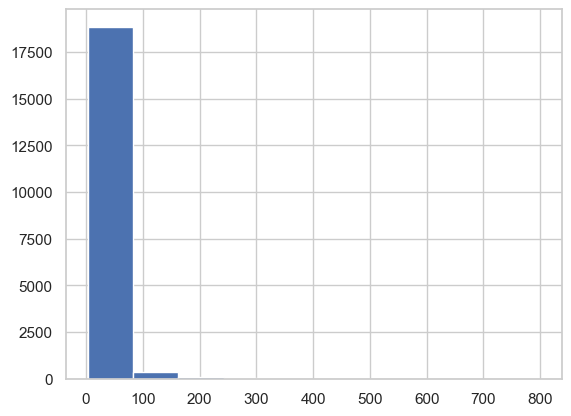

In [269]:
df["upvotes"].hist()

# 3- Data Preparation

### Remove and transform columns

In [271]:
df = df[['title','body','upvotes','created_utc','num_comments','label']]
df['created_utc'] = pd.to_datetime(df['created_utc'],unit='s')
df['created_utc'].dt.tz_localize('UTC').dt.tz_convert('Europe/Amsterdam')
display(df)

,title,body,upvotes,created_utc,num_comments,label
1990777,I feel like I am smart enough that I should be...,I dont mean to say I am _extremely_ smart and ...,11.0,2009-06-19 03:01:24,11.0,1.0
1990779,My story...,Hi everyone Ive been using reddit for a long t...,21.0,2009-06-19 23:09:04,10.0,1.0
1990784,This is very difficult for me. The one person ...,This is an alt account She reads reddit as do ...,17.0,2009-06-22 03:45:11,15.0,1.0
1990785,Further update on bboyer,,19.0,2009-06-22 06:29:55,1.0,1.0
1990790,I need to speak to anyone who is not already t...,And that eliminates just about everyone I know...,16.0,2009-06-24 08:12:19,13.0,1.0
...,...,...,...,...,...,...
14995,"Girls, would you be freaked out by random comp...",The reason I ask this is because lately Ive go...,44.0,2012-09-02 13:11:47,51.0,0.0
14996,Wow what a night...,Tonight I had quite an interesting nightIm up ...,20.0,2012-09-02 11:55:27,26.0,0.0
14997,[rant] I can't keep pretending you're part of ...,I realize this is offsubject etc but I need to...,16.0,2012-09-02 11:17:11,13.0,0.0
14998,teen looking for advice.,I had a bestfriend going into the school year ...,7.0,2012-09-02 10:18:59,3.0,0.0


In [157]:
# valores NaN em 'num_comments' e 'upvotes' para 0
df.loc[df[['num_comments', 'upvotes']].isnull().any(axis=1), ['num_comments', 'upvotes']] = 0
df.isnull().sum()

title               23
body            461051
upvotes              0
created_utc        106
num_comments         0
label              106
dtype: int64

In [189]:
# Separando amostra menor
df_menor = df[df['label'] == 1]
df_menor = df_menor.head(10000)

df_maior = df[df['label'] == 0]
df_maior = df_maior.head(15000)

df = pd.concat([df_menor, df_maior])
df = df.dropna(axis=0, how='any')
df

,title,body,upvotes,created_utc,num_comments,label
1990777,I feel like I am smart enough that I should be...,"I don't mean to say I am _extremely_ smart, an...",11.0,2009-06-19 03:01:24,11.0,1.0
1990779,My story...,Hi everyone.\n\nI've been using reddit for a l...,21.0,2009-06-19 23:09:04,10.0,1.0
1990784,This is very difficult for me. The one person ...,"This is an alt account. She reads reddit, as d...",17.0,2009-06-22 03:45:11,15.0,1.0
1990785,Further update on bboyer,http://www.reddit.com/r/Needafriend/comments/8...,19.0,2009-06-22 06:29:55,1.0,1.0
1990790,I need to speak to anyone who is not already t...,And that eliminates just about everyone I know...,16.0,2009-06-24 08:12:19,13.0,1.0
...,...,...,...,...,...,...
14995,"Girls, would you be freaked out by random comp...",The reason I ask this is because lately I've g...,44.0,2012-09-02 13:11:47,51.0,0.0
14996,Wow what a night...,Tonight I had quite an interesting night....I'...,20.0,2012-09-02 11:55:27,26.0,0.0
14997,[rant] I can't keep pretending you're part of ...,I realize this is off-subject etc. but I need ...,16.0,2012-09-02 11:17:11,13.0,0.0
14998,teen looking for advice.,I had a bestfriend going into the school year ...,7.0,2012-09-02 10:18:59,3.0,0.0


## Pre processing

### Clean Text

In [216]:

def clean_text(texto):

    if isinstance(texto, str):
        # 1. Remover links (URLs)
        texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
        # 2. Remover números
        texto = re.sub(r'\d+', '', texto)
        # 3. Remover caracteres especiais 
        texto = re.sub(r'[^\w\s]', '', texto)
        # 4. Remover emojis
        emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"  # Emoticons
            u"\U0001F300-\U0001F5FF"  # Símbolos e pictogramas
            u"\U0001F680-\U0001F6FF"  # Transporte e símbolos de mapa
            u"\U0001F1E0-\U0001F1FF"  # Bandeiras
            u"\U00002700-\U000027BF"  # Diversos símbolos e pictogramas
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)
        texto = emoji_pattern.sub(r'', texto)
        # 5. Remover espaços extras
        texto = re.sub(r'\s+', ' ', texto).strip()
    
    return texto if isinstance(texto, str) else ""


tqdm.pandas()

# caso queria fazer manual
#df.loc[:, 'title'] = df['title'].progress_apply(clean_text())
#df.loc[:, 'body'] = df['body'].progress_apply(clean_text())




### 1. Stopwords
Stopwords are very common words that frequently appear in texts, but usually do not carry significant information for tasks like sentiment analysis, classification, etc. Examples of stopwords include words like "a", "of", "the", "for", "is", "in", among others. While they are important for grammar and basic sentence understanding, they are often removed during preprocessing because they do not help in understanding the main meaning of the text.

In [218]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(texto):
    palavras = texto.split()
    palavras_filtradas = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_filtradas)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pedrotomielo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



### 2. Stemming
Stemming is the process of reducing words to their "roots" by removing suffixes and prefixes. The idea is that words with similar meanings can be reduced to the same base form. For example, words like "playing", "played", and "play" can be reduced to the common root "play".



In [215]:
stemmer = PorterStemmer()

def stem_text(texto):
    palavras = texto.split()
    palavras_stem = [stemmer.stem(palavra) for palavra in palavras]
    return ' '.join(palavras_stem)


### 3. Lemmatization
Lemmatization is also a process of reducing words to their base form, but unlike stemming, lemmatization takes into account the grammatical and semantic context to produce a more accurate result. Lemmatization transforms a word into its dictionary form (or "lemma"). For example, "running" becomes "run", and "better" becomes "good".

In [213]:

nlp = spacy.load("en_core_web_sm")

def lemmatize_text(texto):
    doc = nlp(texto)
    palavras_lemmatizadas = [token.lemma_ for token in doc]
    return ' '.join(palavras_lemmatizadas)


### Apply functions (optional)

In [165]:
def preprocessamento_completo(texto):

    texto = remove_stopwords(texto)
    #texto = aplicar_stemming(texto)
    texto = lemmatize_text(texto) 
    
    return texto


In [166]:
#df['title'] = df['title'].progress_apply(preprocessamento_completo)
df['body'] = df['body'].progress_apply(preprocessamento_completo)


100%|██████████| 19926/19926 [02:20<00:00, 141.76it/s]


# 4- Modelling

## Train and test split

In [167]:
# tokenizacao para tweets (mesma ideai pro reddit)
tweet_tokenizer = TweetTokenizer()

In [168]:
def confusion_matrix_show(y_test, predict_model):
    print('Classification Report:\n', metrics.classification_report(y_test, predict_model))
    print('Accuracy:', accuracy_score(y_test, predict_model))
    cm = confusion_matrix(y_target=y_test, y_predicted=predict_model, binary=False)
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()
    print('\n')

In [196]:
# Variáveis para treino e teste
X = df['body']
y = df['label']
display(X)
display(y)

1990777    I don't mean to say I am _extremely_ smart, an...
1990779    Hi everyone.\n\nI've been using reddit for a l...
1990784    This is an alt account. She reads reddit, as d...
1990785    http://www.reddit.com/r/Needafriend/comments/8...
1990790    And that eliminates just about everyone I know...
                                 ...                        
14995      The reason I ask this is because lately I've g...
14996      Tonight I had quite an interesting night....I'...
14997      I realize this is off-subject etc. but I need ...
14998      I had a bestfriend going into the school year ...
14999      Soo there is this girl that I liked slash stil...
Name: body, Length: 19325, dtype: object

1990777    1.0
1990779    1.0
1990784    1.0
1990785    1.0
1990790    1.0
          ... 
14995      0.0
14996      0.0
14997      0.0
14998      0.0
14999      0.0
Name: label, Length: 19325, dtype: float64

In [197]:
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Verificando as formas após a conversão
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(15460,) (15460,) (3865,) (3865,)


## CountVectorizer:
It converts text into a matrix of word counts. Each column represents a unique word (or "token"), and each row represents the number of times that word appears in a document. It generates a sparse vector (mostly zeros) where each entry is the count of a specific word in each document. This is useful for capturing frequency, but it doesn't consider the relevance of words across different documents. With the parameter analyzer='word', it analyzes by words.

In [171]:
count_tokenizer = CountVectorizer(analyzer='word', tokenizer=tweet_tokenizer.tokenize)

## TfidfVectorizer (Term Frequency-Inverse Document Frequency):
It works similarly to CountVectorizer but takes into account the importance of words across the entire set of documents. It calculates a word's frequency in a document (TF) adjusted by the inverse frequency of the word across all documents (IDF). This reduces the weight of common words, making the model focus more on distinctive words. Thus, unlike CountVectorizer, it weights words to give more importance to those that are rare across documents, which can improve accuracy in classification tasks.

In [172]:
tfid_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=tweet_tokenizer.tokenize)

## Logistic Regression
Logistic Regression is a classification model, not a regression model. It works by modeling the probability of a sample belonging to a particular class. It calculates a logistic (sigmoid) function over a linear combination of input features and uses this function to predict a probability. The parameter solver='liblinear' defines the numerical method used to optimize the model. It is useful for binary problems (two labels) and can be extended to multiple classes using techniques like "one-vs-rest."

#### tfid Vectorizer

Logistic Regression with -> tfid_Vectorizer:
Accuracy: 0.913065976714101


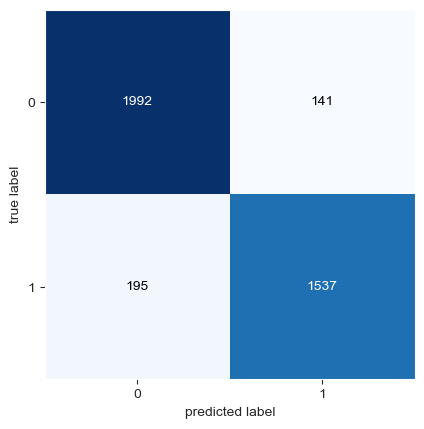

In [198]:

X_train_vect = tfid_vectorizer.fit_transform(X_train)
X_test_vect = tfid_vectorizer.transform(X_test)


model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_vect, y_train)


y_pred = model.predict(X_test_vect)
accuracy_logistic_tfid = accuracy_score(y_test, y_pred)

print('Logistic Regression with -> tfid_Vectorizer:')
print("Accuracy:", accuracy_logistic_tfid)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print('\n')


#### Count Vectorizer

Logistic Regression with -> CountVectorizer:
Accuracy: 0.9071151358344114


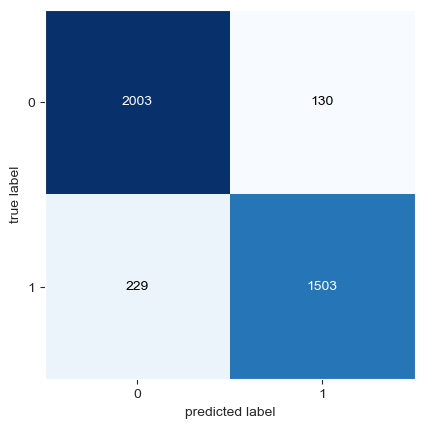

In [199]:

X_train_vect = count_tokenizer.fit_transform(X_train)  
X_test_vect = count_tokenizer.transform(X_test) 


model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_vect, y_train)


y_pred = model.predict(X_test_vect)
accuracy_logistic_count = accuracy_score(y_test, y_pred)

print('Logistic Regression with -> CountVectorizer:')
print("Accuracy:", accuracy_logistic_count)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print('\n')

## Passive Aggressive Classifier
The Passive Aggressive Classifier is an efficient model for online classification problems, ideal for large volumes of streaming data. It is "passive" when the prediction is correct, making no adjustments, and "aggressive" when it makes an error, updating the coefficients slightly to correct the mistake. Since it doesn’t have a continuous loss function, it can learn quickly. However, it may be sensitive to noise and requires careful parameter tuning.

#### tfid Vectorizer

Passive agressive model with -> tfid_Vectorizer:
Accuracy: 0.8985769728331178


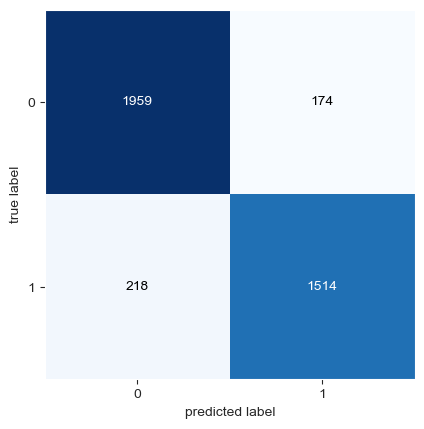

In [200]:
X_train_vect = tfid_vectorizer.fit_transform(X_train)
X_test_vect = tfid_vectorizer.transform(X_test)


model = PassiveAggressiveClassifier(random_state=42)
model.fit(X_train_vect, y_train)


y_pred = model.predict(X_test_vect)
passive_agressive_tfid = accuracy_score(y_test, y_pred)

print('Passive agressive model with -> tfid_Vectorizer:')
print("Accuracy:", passive_agressive_tfid)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print('\n')


#### Count Vectorizer

Passive agressive model with -> Count Tokenizer:
Accuracy: 0.8758085381630013


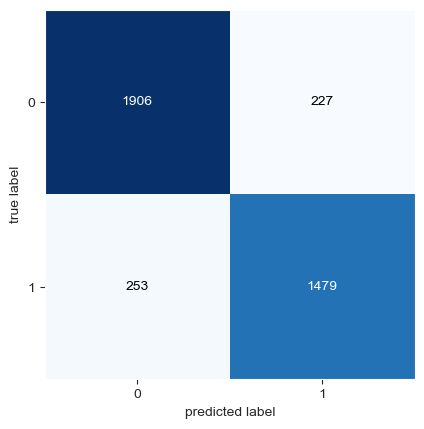

In [201]:

X_train_vect = count_tokenizer.fit_transform(X_train)
X_test_vect = count_tokenizer.transform(X_test)


model = PassiveAggressiveClassifier(random_state=42)
model.fit(X_train_vect, y_train)


y_pred = model.predict(X_test_vect)
passive_agressive_count = accuracy_score(y_test, y_pred)

print('Passive agressive model with -> Count Tokenizer:')
print("Accuracy:", passive_agressive_count)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print('\n')



# Random Forest Classifier:
A model of ensemble learning that uses multiple decision trees (binary trees that make decisions based on features). Each tree is built from a random sample of the data and makes a prediction. The forest then votes on the most common class among the trees for each sample. It performs well on complex problems and is generally robust to noisy data, but it can be slower compared to other methods on large datasets.

#### tfid Vectorizer

Random Forest with -> tfid_Vectorizer:
Accuracy: 0.8685640362225097


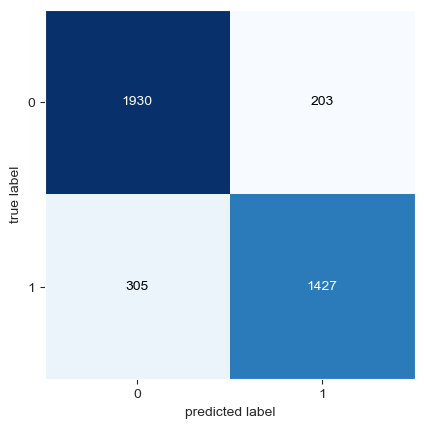

In [202]:
X_train_vect = tfid_vectorizer.fit_transform(X_train)
X_test_vect = tfid_vectorizer.transform(X_test)


model = RandomForestClassifier(random_state=42)
model.fit(X_train_vect, y_train)


y_pred = model.predict(X_test_vect)
random_forest_tfid = accuracy_score(y_test, y_pred)

print('Random Forest with -> tfid_Vectorizer:')
print("Accuracy:", random_forest_tfid)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print('\n')


#### Count Vectorizer

Random Forest with -> Count Tokenizer:
Accuracy: 0.8595084087968952


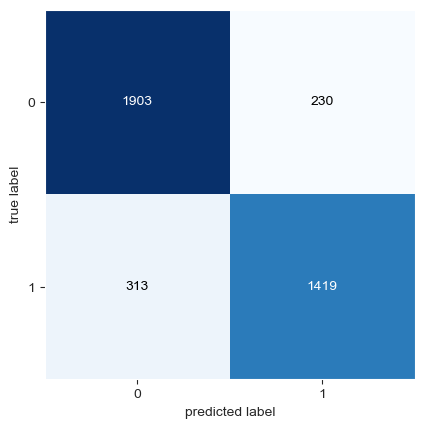

In [203]:
X_train_vect = count_tokenizer.fit_transform(X_train)
X_test_vect = count_tokenizer.transform(X_test)


model = RandomForestClassifier(random_state=42)
model.fit(X_train_vect, y_train)


y_pred = model.predict(X_test_vect)
random_forest_count = accuracy_score(y_test, y_pred)

print('Random Forest with -> Count Tokenizer:')
print("Accuracy:", random_forest_count)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print('\n')


## Naive Bayes Classifier:
Naive Bayes is a simple probabilistic classifier based on Bayes' Theorem. It assumes that all features are independent, which makes the calculations easier. Despite its simplicity, it performs well in tasks like text classification and spam detection. It’s fast, requires little training data, but may struggle with complex dependencies between features.

tfid tokenizer

Naive Bayes -> tfid Tokenizer:
Accuracy: 0.8589909443725744


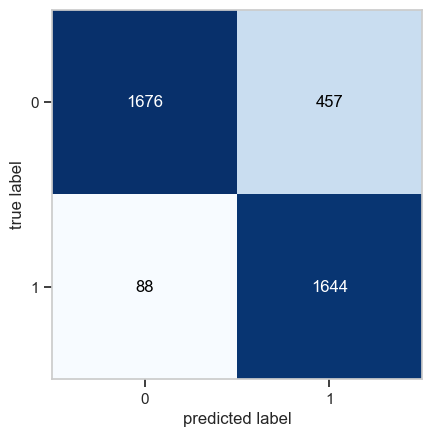

In [275]:
X_train_vect = tfid_vectorizer.fit_transform(X_train)
X_test_vect = tfid_vectorizer.transform(X_test)


model = MultinomialNB()
model.fit(X_train_vect, y_train)


y_pred = model.predict(X_test_vect)
naive_tfid = accuracy_score(y_test, y_pred)

print('Naive Bayes -> tfid Tokenizer:')
print("Accuracy:", naive_tfid)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print('\n')

Count tokenizer

Naive Bayes -> Count Tokenizer:
Accuracy: 0.8548512289780078


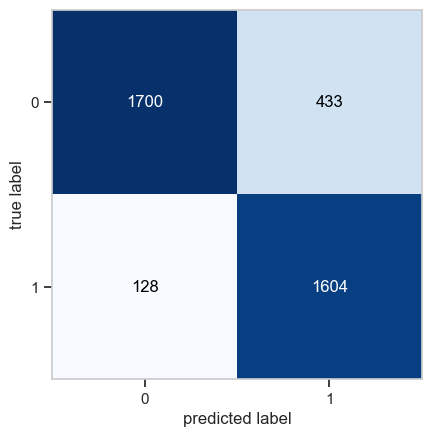

In [276]:
    
X_train_vect = count_tokenizer.fit_transform(X_train)
X_test_vect = count_tokenizer.transform(X_test)


model = MultinomialNB()
model.fit(X_train_vect, y_train)


y_pred = model.predict(X_test_vect)
naive_count = accuracy_score(y_test, y_pred)

print('Naive Bayes -> Count Tokenizer:')
print("Accuracy:", naive_count)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print('\n')


## Support Vector Machine (SVM):
SVM is a machine learning algorithm used for classification and regression. It finds the optimal hyperplane that separates data into different classes, maximizing the margin between them. SVM works well in high-dimensional spaces and can handle non-linear data with kernel functions, but it can be slow with large datasets.

Svm -> tfid Tokenizer:
Accuracy: 0.9247089262613195


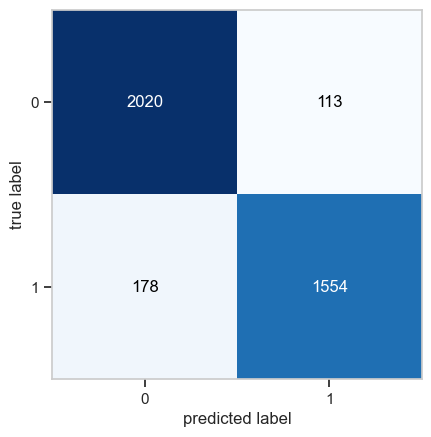

In [278]:
X_train_vect = tfid_vectorizer.fit_transform(X_train)
X_test_vect = tfid_vectorizer.transform(X_test)


model = SVC(random_state=42)
model.fit(X_train_vect, y_train)


y_pred = model.predict(X_test_vect)
svm_tfid = accuracy_score(y_test, y_pred)

print('Svm -> tfid Tokenizer:')
print("Accuracy:", svm_tfid)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print('\n')


Count tokenizer

Svm -> Count Tokenizer:
Accuracy: 0.8846054333764554


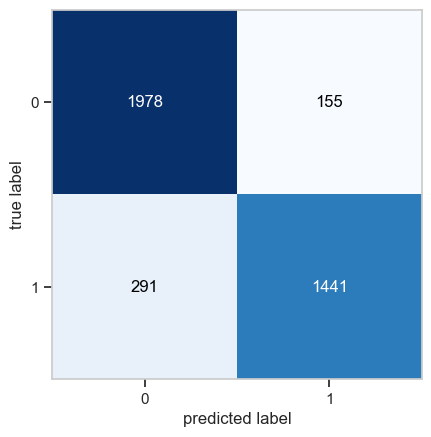

In [277]:
X_train_vect = count_tokenizer.fit_transform(X_train)
X_test_vect = count_tokenizer.transform(X_test)


model = SVC(random_state=42)
model.fit(X_train_vect, y_train)


y_pred = model.predict(X_test_vect)
svm_count = accuracy_score(y_test, y_pred)

print('Svm -> Count Tokenizer:')
print("Accuracy:", svm_count)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print('\n')


# 5- Evaluation

In [280]:
avaliate = pd.DataFrame({
    "Model": [
        'Logistic Regression', 'Logistic Regression', 
        'Passive Aggressive Classifier', 'Passive Aggressive Classifier', 
        'Random Forest Classifier', 'Random Forest Classifier', 
        'Naive Bayes', 'Naive Bayes', 
        'SVM Classifier', 'SVM Classifier'
    ],
    "Vectorizer": [
        'CountVectorizer', 'TfidfVectorizer', 
        'CountVectorizer', 'TfidfVectorizer', 
        'CountVectorizer', 'TfidfVectorizer',
        'CountVectorizer', 'TfidfVectorizer',
        'CountVectorizer', 'TfidfVectorizer'
    ],
    "Accuracy": [accuracy_logistic_count, accuracy_logistic_tfid, 
                 passive_agressive_count, passive_agressive_tfid, 
                 random_forest_count, random_forest_tfid, 
                 naive_count, naive_tfid, 
                 svm_count, svm_tfid]
})

# Exibir o DataFrame
display(avaliate)


,Model,Vectorizer,Accuracy
0,Logistic Regression,CountVectorizer,0.907115
1,Logistic Regression,TfidfVectorizer,0.913066
2,Passive Aggressive Classifier,CountVectorizer,0.875809
3,Passive Aggressive Classifier,TfidfVectorizer,0.898577
4,Random Forest Classifier,CountVectorizer,0.854851
5,Random Forest Classifier,TfidfVectorizer,0.868564
6,Naive Bayes,CountVectorizer,0.854851
7,Naive Bayes,TfidfVectorizer,0.858991
8,SVM Classifier,CountVectorizer,0.884605
9,SVM Classifier,TfidfVectorizer,0.924709


### Model of differents vectorizers

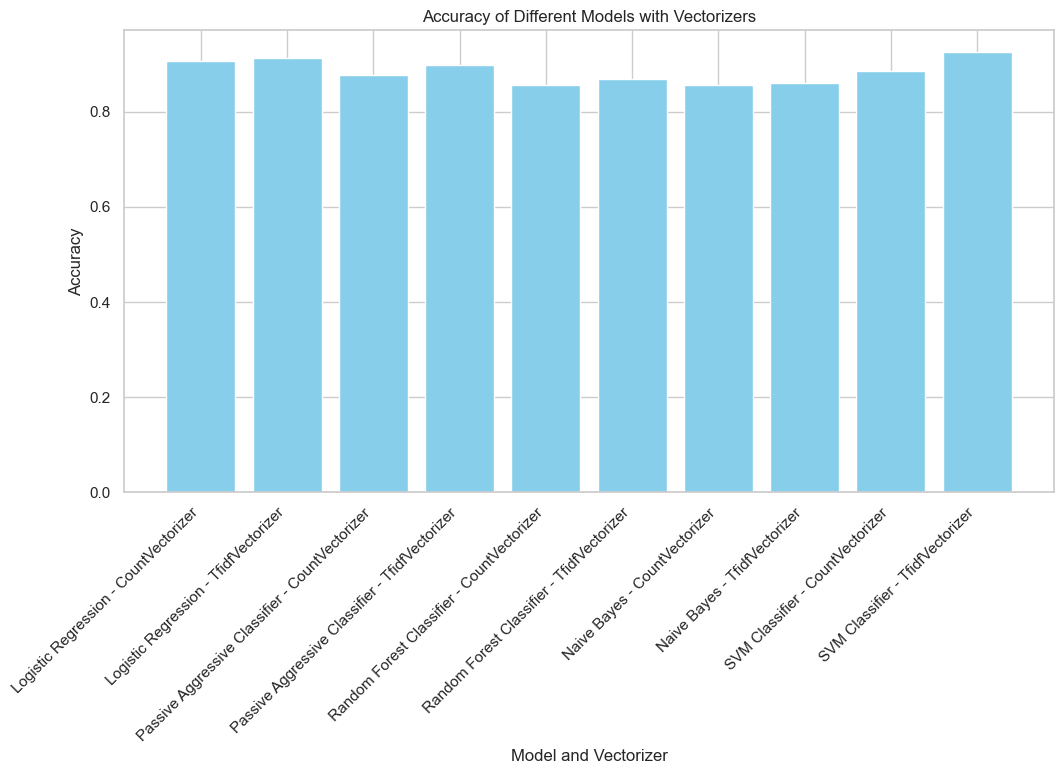

In [281]:
avaliate["Model_Vectorizer"] = avaliate["Model"] + " - " + avaliate["Vectorizer"]

plt.figure(figsize=(12, 6))
plt.bar(avaliate["Model_Vectorizer"], avaliate["Accuracy"], color='skyblue')

plt.title("Accuracy of Different Models with Vectorizers")
plt.xlabel("Model and Vectorizer")
plt.ylabel("Accuracy")

plt.xticks(rotation=45, ha="right")

plt.show()


## Median of different vectorizer

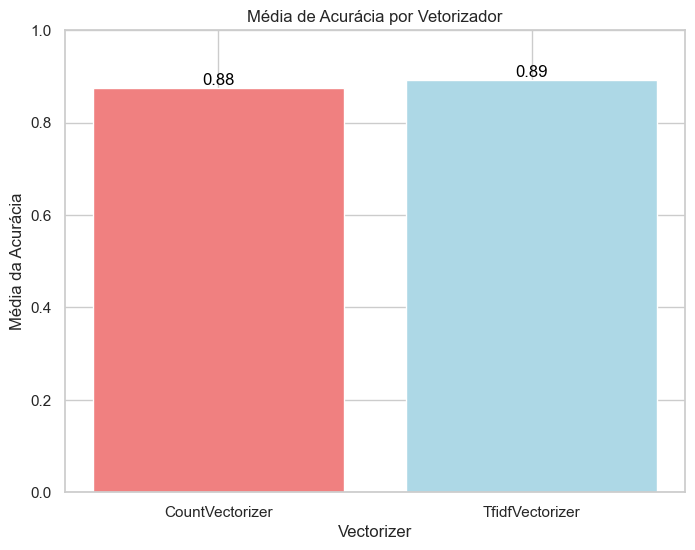

In [282]:
mean_accuracy = avaliate.groupby("Vectorizer")["Accuracy"].mean()


plt.figure(figsize=(8, 6))
bars = plt.bar(mean_accuracy.index, mean_accuracy, color=['lightcoral', 'lightblue'])

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", 
        ha="center", va="bottom", fontsize=12, color="black"
    )

plt.title("Média de Acurácia por Vetorizador")
plt.xlabel("Vectorizer")
plt.ylabel("Média da Acurácia")
plt.ylim(0, 1)  
plt.xticks(rotation=0)


plt.show()


### Testing Different Models, Vectorizers, and Preprocessing Techniques

In [225]:
def test_preprocessing_models_and_vectorizers(texts, labels, models, vectorizers):

    results = []
    
    preprocessors = {
        'sem limpeza': lambda x: x, 
        'limpeza': clean_text,
        'sem stopwords': remove_stopwords,
        'lemmatizacao': lemmatize_text,
        'stemming': stem_text,
        'limpeza + stopwords': lambda x: remove_stopwords(clean_text(x)),
        'limpeza + lematizacao': lambda x: lemmatize_text(clean_text(x)),
        'limpeza + stemming': lambda x: stem_text(clean_text(x)),
        'stop words + limpeza + lemmatization': lambda x: remove_stopwords(lemmatize_text(clean_text(x))),
        'stop words + limpeza + steaming': lambda x: remove_stopwords(stem_text(clean_text(x)))
    }

    for name, preprocess in preprocessors.items():
        print(f"Testando: {name}")
        
        processed_texts = [preprocess(text) for text in texts]
        
        for vectorizer_name, vectorizer in vectorizers.items():
            print(f"  - Usando vetorizador: {vectorizer_name}")
            
            X = vectorizer.fit_transform(processed_texts)
            
            X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)
            
            for model_name, model in models.items():
                print(f"    - Usando modelo: {model_name}")
                
                model.fit(X_train, y_train)
                
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                
         
                results.append({
                    'Pré-processamento': name,
                    'Vetorizador': vectorizer_name,
                    'Modelo': model_name,
                    'Acurácia': accuracy
                })
                print(f"      Acurácia: {accuracy:.4f}")
            print('-' * 40)


    df_results = pd.DataFrame(results)
    return df_results


models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Passive agressive classifier': PassiveAggressiveClassifier(random_state=42),
    'SVM': SVC(random_state=42) 
}


vectorizers = {
    'Count Vectorizer': CountVectorizer(analyzer='word', tokenizer=tweet_tokenizer.tokenize),
    'TF-IDF Vectorizer': TfidfVectorizer(analyzer='word', tokenizer=tweet_tokenizer.tokenize)
}

df_results = test_preprocessing_models_and_vectorizers(df['body'], df['label'], models, vectorizers)

print(df_results)


Testando: sem limpeza
  - Usando vetorizador: Count Vectorizer
    - Usando modelo: Logistic Regression
      Acurácia: 0.9060
    - Usando modelo: Random Forest
      Acurácia: 0.8493
    - Usando modelo: Naive Bayes
      Acurácia: 0.8427
    - Usando modelo: Passive agressive classifier
      Acurácia: 0.8613
    - Usando modelo: SVM
      Acurácia: 0.8788
----------------------------------------
  - Usando vetorizador: TF-IDF Vectorizer
    - Usando modelo: Logistic Regression
      Acurácia: 0.9060
    - Usando modelo: Random Forest
      Acurácia: 0.8587
    - Usando modelo: Naive Bayes
      Acurácia: 0.8374
    - Usando modelo: Passive agressive classifier
      Acurácia: 0.8948
    - Usando modelo: SVM
      Acurácia: 0.9153
----------------------------------------
Testando: limpeza
  - Usando vetorizador: Count Vectorizer
    - Usando modelo: Logistic Regression
      Acurácia: 0.9060
    - Usando modelo: Random Forest
      Acurácia: 0.8493
    - Usando modelo: Naive Bayes
 

In [227]:
display(df_results)

,Pré-processamento,Vetorizador,Modelo,Acurácia
0,sem limpeza,Count Vectorizer,Logistic Regression,0.906002
1,sem limpeza,Count Vectorizer,Random Forest,0.849258
2,sem limpeza,Count Vectorizer,Naive Bayes,0.842704
3,sem limpeza,Count Vectorizer,Passive agressive classifier,0.861331
4,sem limpeza,Count Vectorizer,SVM,0.878751
...,...,...,...,...
95,stop words + limpeza + steaming,TF-IDF Vectorizer,Logistic Regression,0.910659
96,stop words + limpeza + steaming,TF-IDF Vectorizer,Random Forest,0.871852
97,stop words + limpeza + steaming,TF-IDF Vectorizer,Naive Bayes,0.832011
98,stop words + limpeza + steaming,TF-IDF Vectorizer,Passive agressive classifier,0.882718


## Models Analysis

In [257]:
# Calcular a média de acurácia por Modelo
mean_accuracy_model = df_results.groupby('Modelo')['Acurácia'].mean().sort_values(ascending=False)
print("\nMédia de Acurácia por Modelo:")
print(mean_accuracy_model)


Média de Acurácia por Modelo:
Modelo
Logistic Regression             0.904096
SVM                             0.899181
Passive agressive classifier    0.872827
Random Forest                   0.859141
Naive Bayes                     0.837168
Name: Acurácia, dtype: float64


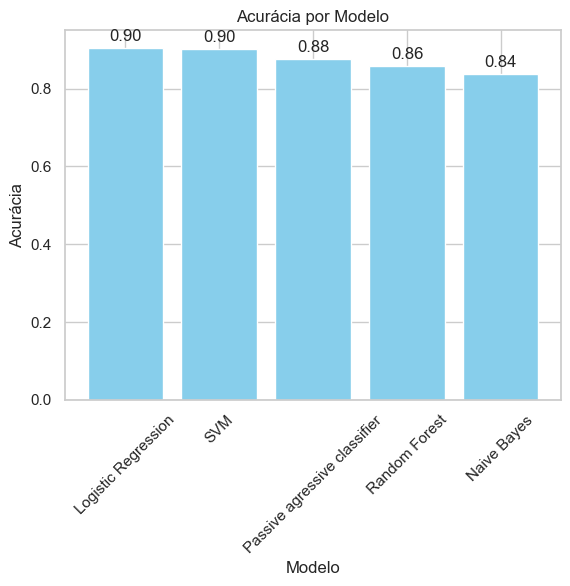

In [244]:
group_model = df_results[['Modelo', 'Acurácia']].groupby('Modelo').median()
group_model = group_model.sort_values('Acurácia', ascending=False)
plt.bar(group_model.index, group_model['Acurácia'], color='skyblue')

for i, v in enumerate(group_model['Acurácia']):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

# Rótulos e título
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Acurácia por Modelo')
plt.xticks(rotation=45)
plt.show()


## Pre Processing Analysis

In [258]:
# Calcular a média de acurácia por Pré-processamento
mean_accuracy_preprocessing = df_results.groupby('Pré-processamento')['Acurácia'].mean().sort_values(ascending=False)
print("Média de Acurácia por Pré-processamento:")
print(mean_accuracy_preprocessing)

Média de Acurácia por Pré-processamento:
Pré-processamento
limpeza + stemming                      0.876716
stemming                                0.876716
stop words + limpeza + steaming         0.876147
lemmatizacao                            0.876043
limpeza + lematizacao                   0.876043
limpeza                                 0.875026
sem limpeza                             0.875026
limpeza + stopwords                     0.871387
sem stopwords                           0.871387
stop words + limpeza + lemmatization    0.870335
Name: Acurácia, dtype: float64


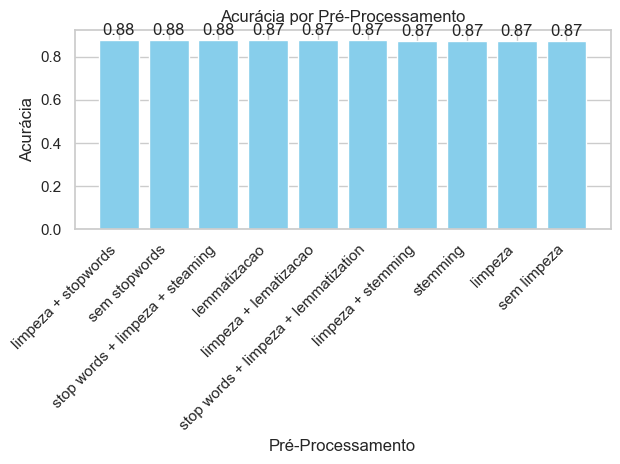

In [252]:
group_pre_process = df_results[['Pré-processamento', 'Acurácia']].groupby('Pré-processamento').median()
group_pre_process = group_pre_process.sort_values('Acurácia', ascending=False)
plt.bar(group_pre_process.index, group_pre_process['Acurácia'], color='skyblue')


for i, v in enumerate(group_pre_process['Acurácia']):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.xlabel('Pré-Processamento')
plt.ylabel('Acurácia')
plt.title('Acurácia por Pré-Processamento')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Vectorizers Analysis

In [259]:
# Calcular a média de acurácia por Vetorizador
mean_accuracy_vectorizer = df_results.groupby('Vetorizador')['Acurácia'].mean().sort_values(ascending=False)
print("\nMédia de Acurácia por Vetorizador:")
print(mean_accuracy_vectorizer)


Média de Acurácia por Vetorizador:
Vetorizador
TF-IDF Vectorizer    0.881828
Count Vectorizer     0.867137
Name: Acurácia, dtype: float64


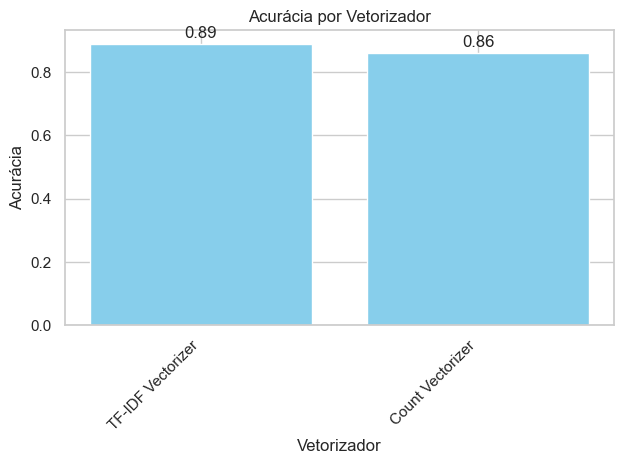

In [253]:
group_vector = df_results[['Vetorizador', 'Acurácia']].groupby('Vetorizador').median()
group_vector = group_vector.sort_values('Acurácia', ascending=False)
plt.bar(group_vector.index, group_vector['Acurácia'], color='skyblue')

for i, v in enumerate(group_vector['Acurácia']):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')


plt.xlabel('Vetorizador')
plt.ylabel('Acurácia')
plt.title('Acurácia por Vetorizador')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Best Results

In [234]:
# Encontrar a linha com a maior acurácia
best_combination = df_results.loc[df_results['Acurácia'].idxmax()]
print("Melhor Combinação (Maior Acurácia):")
print(best_combination)


Melhor Combinação (Maior Acurácia):
Pré-processamento         lemmatizacao
Vetorizador          TF-IDF Vectorizer
Modelo                             SVM
Acurácia                       0.91842
Name: 39, dtype: object


# Worse Results

In [235]:
# Encontrar a linha com a menor acurácia
worst_combination = df_results.loc[df_results['Acurácia'].idxmin()]

print("\nPior Combinação (Menor Acurácia):")
print(worst_combination)



Pior Combinação (Menor Acurácia):
Pré-processamento        sem stopwords
Vetorizador          TF-IDF Vectorizer
Modelo                     Naive Bayes
Acurácia                      0.817868
Name: 27, dtype: object



## Accuracy Average by Preprocessing and Model Combination

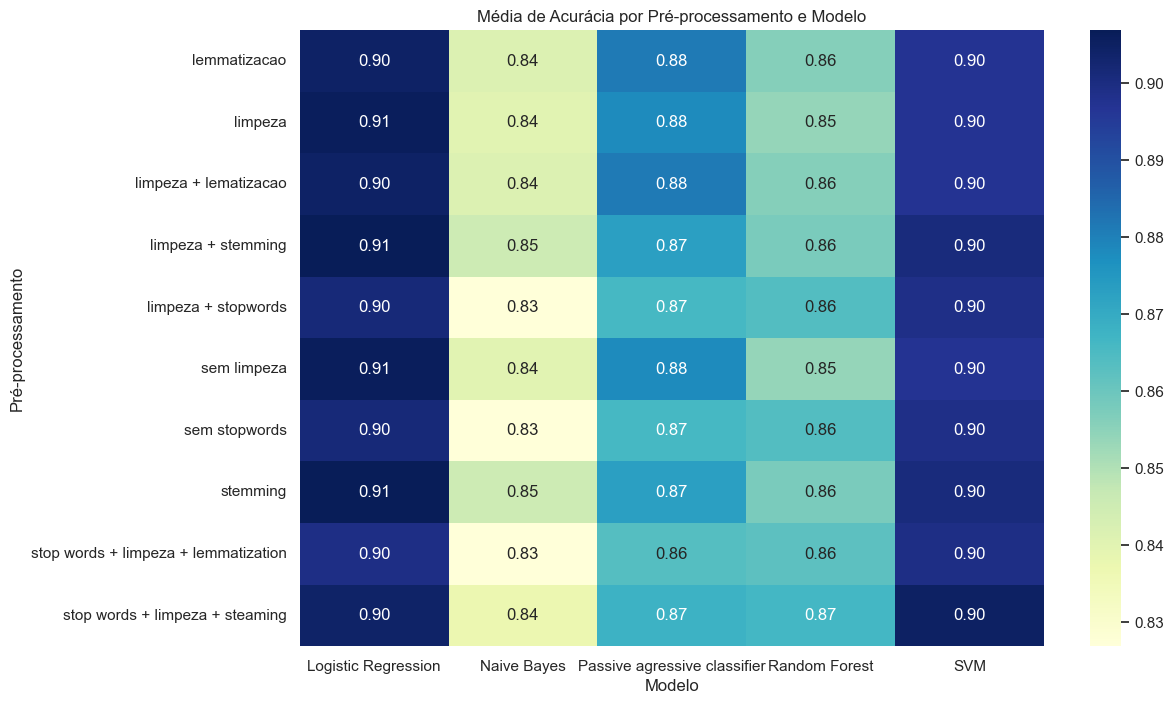

In [260]:
import seaborn as sns
heatmap_data = df_results.pivot_table(
    index='Pré-processamento', 
    columns='Modelo', 
    values='Acurácia', 
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Média de Acurácia por Pré-processamento e Modelo")
plt.show()

## Accuracy Average for Each Vectorizer and Model Combination







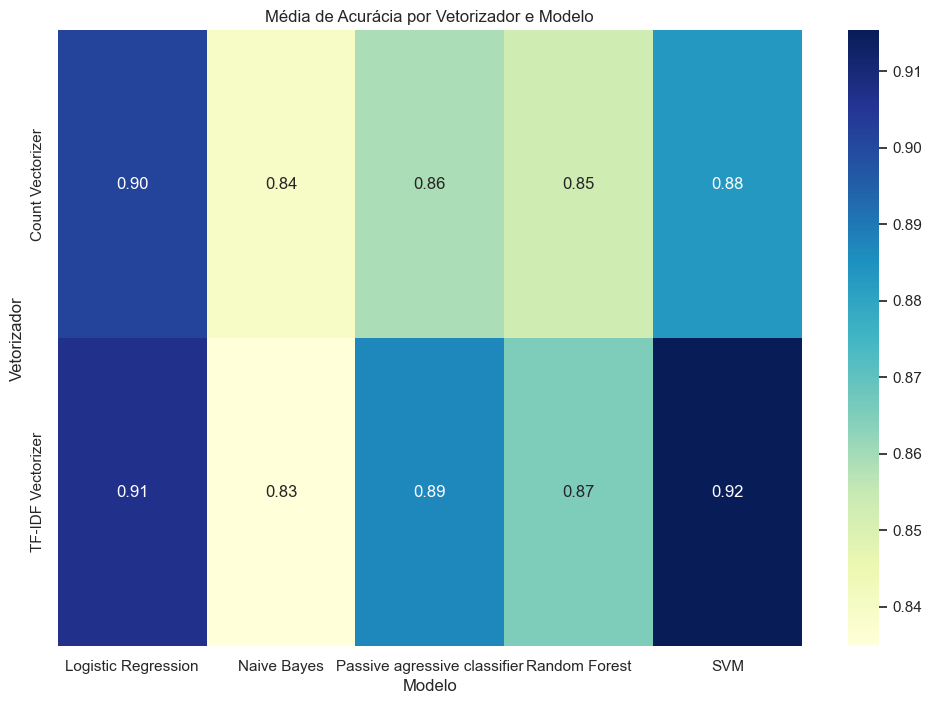

In [263]:
heatmap_data_vm = df_results.pivot_table(
    index='Vetorizador', 
    columns='Modelo', 
    values='Acurácia', 
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_vm, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Média de Acurácia por Vetorizador e Modelo")
plt.show()

## Accuracy Average for Each Vectorizer and Preprocessing Combination



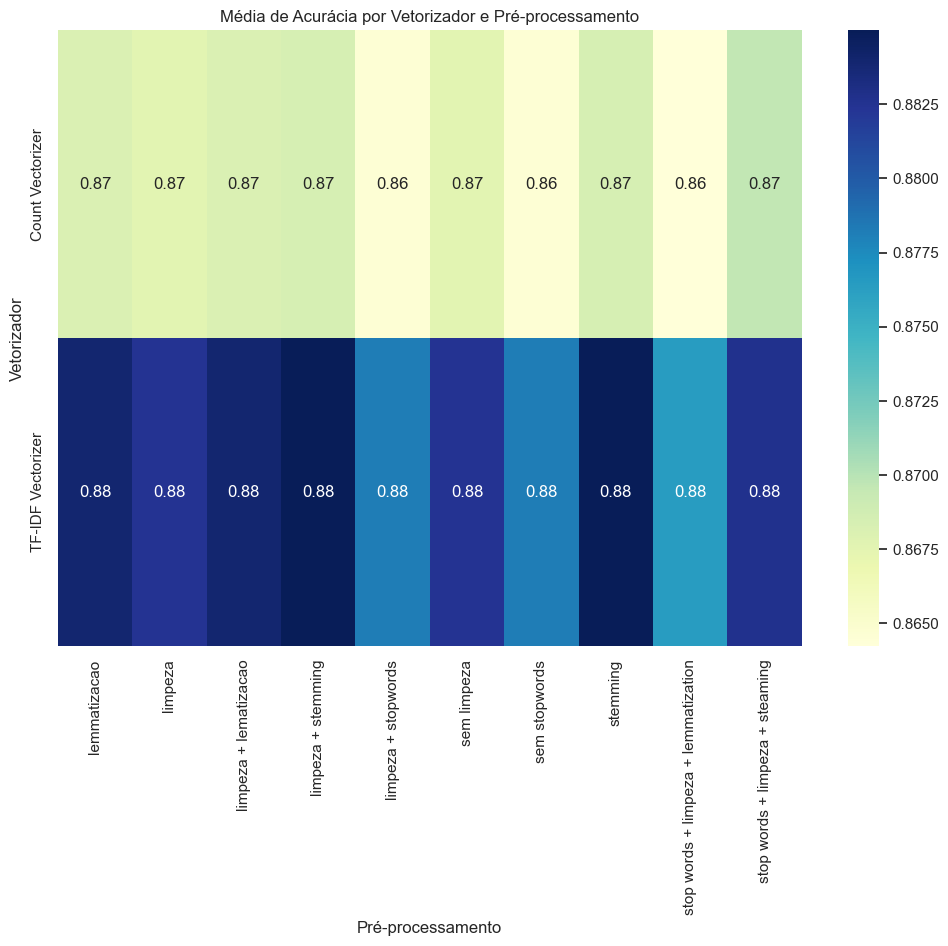

In [264]:
heatmap_data_vp = df_results.pivot_table(
    index='Vetorizador', 
    columns='Pré-processamento', 
    values='Acurácia', 
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_vp, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Média de Acurácia por Vetorizador e Pré-processamento")
plt.show()


## Accuracy by Vectorizer

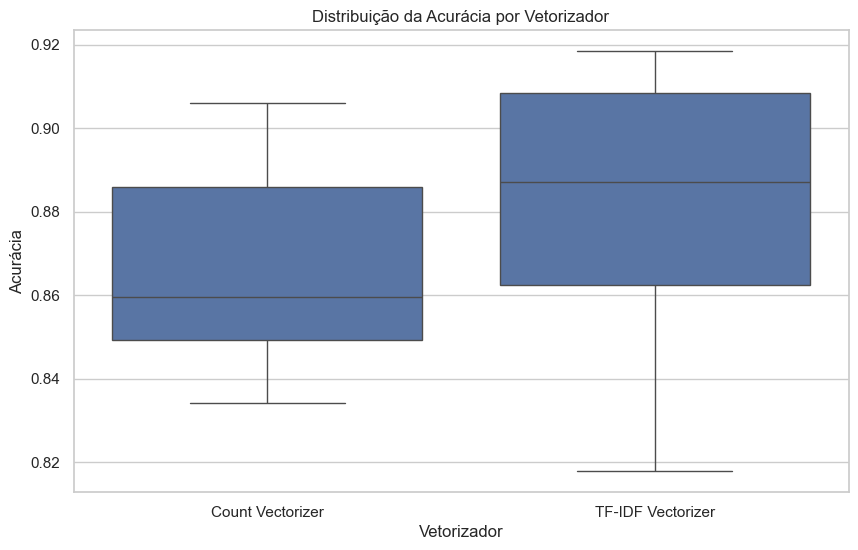

In [261]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_results, x='Vetorizador', y='Acurácia')
plt.title("Distribuição da Acurácia por Vetorizador")
plt.show()

## Accuracy by Model

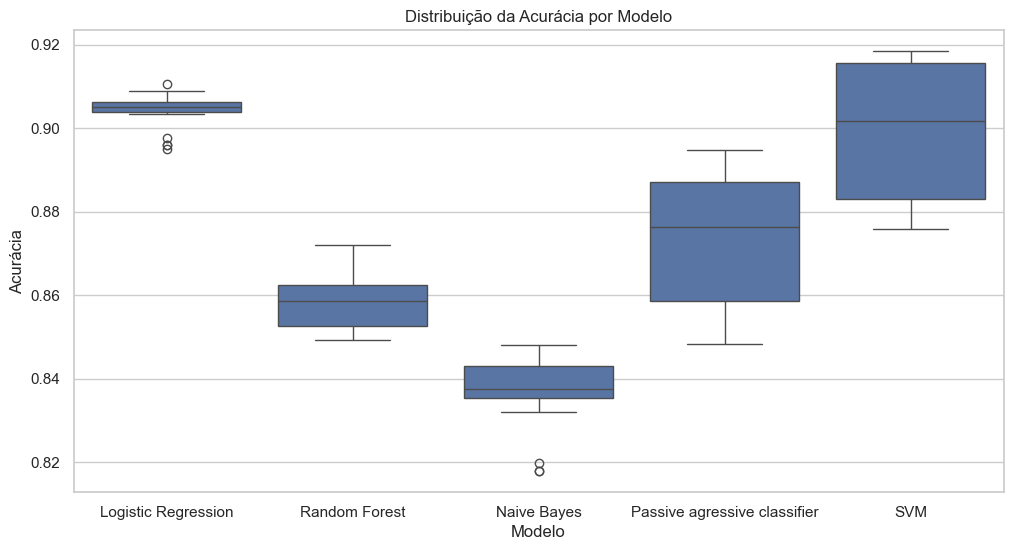

In [262]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, x='Modelo', y='Acurácia')
plt.title("Distribuição da Acurácia por Modelo")
plt.show()